In [1]:
%% load raw ECoG voltage timeseries
load ecog_fastslow.mat

Let's see what variables were just loaded...

In [2]:
whos

  Name                        Size                  Bytes  Class     Attributes

  fs                          1x1                       8  double              
  t                           1x135200            1081600  double              
  volt_aud_intact_1      135200x1                 1081600  double              
  volt_aud_intact_2      135200x1                 1081600  double              
  volt_aud_scram_1       135200x1                 1081600  double              
  volt_aud_scram_2       135200x1                 1081600  double              
  volt_pfc_intact_1      135200x1                 1081600  double              
  volt_pfc_intact_2      135200x1                 1081600  double              
  volt_pfc_scram_1       135200x1                 1081600  double              
  volt_pfc_scram_2       135200x1                 1081600  double              



The variable `fs` is the sampling rate (in Hz) of the voltage timeseries. This was 400Hz.  
The variable `t` is the time axis (in seconds) of the timeseries. About 5 minutes of data.  

There are 8 vectors whose names begin with `volt_`. These are voltage timeseries data from different conditions and locations. Each measurement is a timeseries from a single trial. The timeseries have names that indicate:
 *  `aud`/`pfc`         : whether the recording channel is in auditory or frontal cortex
 *  `intact`/`scram`    : whether the intact or scrambled stimulus was presented
 *  `1` / `2`           : whether it was the first or second presentation of the stimulus


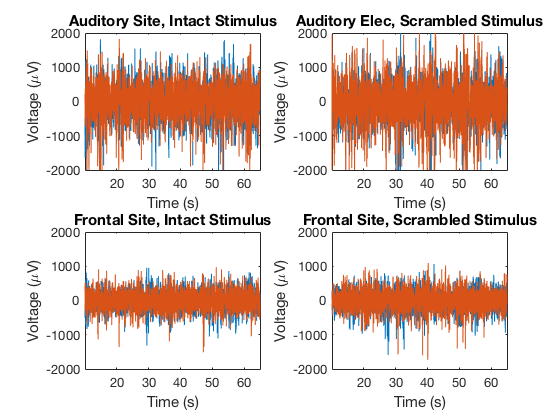

In [3]:
%% now we plot some of the voltage timeseries to have a look at the data
tt = find(and(t > 10, t < 65));   %define a convenient time window for viewing data


figure(9)
subplot(2,2,1)
plot(t(tt), [volt_aud_intact_1(tt) volt_aud_intact_2(tt)])
title('Auditory Site, Intact Stimulus')
subplot(2,2,2)
plot(t(tt), [volt_aud_scram_1(tt) volt_aud_scram_2(tt)])
title('Auditory Elec, Scrambled Stimulus')
subplot(2,2,3)
plot(t(tt), [volt_pfc_intact_1(tt) volt_pfc_intact_2(tt)])
title('Frontal Site, Intact Stimulus')
subplot(2,2,4)
plot(t(tt), [volt_pfc_scram_1(tt) volt_pfc_scram_2(tt)])
title('Frontal Site, Scrambled Stimulus')

myaxis = [t(tt(1))  t(tt(end))  -2000 2000];
for ip = 1:4
    subplot(2,2,ip)
    axis(myaxis)
    xlabel('Time (s)'); ylabel('Voltage (\muV)'); 
end

In [18]:
%% What does the power spectrum of a single channel look like?

Nsamp = length(volt_aud_intact_1); %number of samples
[pspec_aud, fqax] = calc_pspec(buffer(zscore(volt_aud_intact_1), floor(Nsamp/20)), fs);
[pspec_pfc, fqax] = calc_pspec(buffer(zscore(volt_pfc_intact_1), floor(Nsamp/20)), fs);


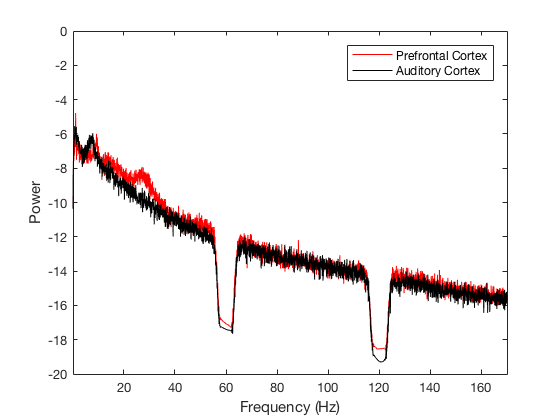

In [24]:
%% What do these power spectra tell us about the speed of population activity in auditory cortex and PFC?
myaxis = [0.1 170 -20 0];
figure(7)
plot(fqax, mean(log(pspec_pfc),2), 'r', fqax, mean(log(pspec_aud),2), 'k')
axis(myaxis)
xlabel('Frequency (Hz)'); ylabel('Power'); legend('Prefrontal Cortex', 'Auditory Cortex');




In [20]:
%% Now let's extract high-frequency power timeseries from the voltage timeseries

mysmth = hamming(fs);       %construct a smoothing window (~1 second Hamming window)
high_freq_band = [70 200];  %define a range of frequencies that compore our "high frequency band"

% now extract power from each time series 
% [this would be much simpler in a loop, but perhaps not as clear

% prefrontal electrode, intact stimulus, run 1 and 2
pow_pfc_intact_1 = filtfilt(mysmth, 1, bbpower(volt_pfc_intact_1, fs, high_freq_band));  %broadband power timeseries for run 1
pow_pfc_intact_2 = filtfilt(mysmth, 1, bbpower(volt_pfc_intact_2, fs, high_freq_band));  %broadband power timeseries for run 1

% prefrontal electrode, scrambled stimulus, run 1 and 2
pow_pfc_scram_1 = filtfilt(mysmth, 1, bbpower(volt_pfc_scram_1, fs, high_freq_band));  %broadband power timeseries for run 1
pow_pfc_scram_2 = filtfilt(mysmth, 1, bbpower(volt_pfc_scram_2, fs, high_freq_band));  %broadband power timeseries for run 1

% near-auditory cortex electrode, intact stimulus, run 1 and 2
pow_aud_intact_1 = filtfilt(mysmth, 1, bbpower(volt_aud_intact_1, fs, high_freq_band));  %broadband power timeseries for run 1
pow_aud_intact_2 = filtfilt(mysmth, 1, bbpower(volt_aud_intact_2, fs, high_freq_band));  %broadband power timeseries for run 1

% near-auditory cortex electrode, scrambled stimulus, run 1 and 2
pow_aud_scram_1 = filtfilt(mysmth, 1, bbpower(volt_aud_scram_1, fs, high_freq_band));  %broadband power timeseries for run 1
pow_aud_scram_2 = filtfilt(mysmth, 1, bbpower(volt_aud_scram_2, fs, high_freq_band));  %broadband power timeseries for run 1


% now we will remove the start and end of our timeseries data, to avoid any transients that could arise from filtering.
% and we will z-score each timeseries to zero mean and unit variance

mycrop = find(and(t >= 0, t < 320)); %index timepoints we'll want to keep
timebase = t(mycrop);    %this is the corresponding timepoints
Nsamp = length(timebase);    %number of timepoints in the set we keep
    
pow_aud_intact_1 = zscore(pow_aud_intact_1(mycrop));
pow_aud_intact_2 = zscore(pow_aud_intact_2(mycrop));
pow_aud_scram_1 = zscore(pow_aud_scram_1(mycrop));
pow_aud_scram_2 = zscore(pow_aud_scram_2(mycrop));

pow_pfc_intact_1 = zscore(pow_pfc_intact_1(mycrop));
pow_pfc_intact_2 = zscore(pow_pfc_intact_2(mycrop));
pow_pfc_scram_1 = zscore(pow_pfc_scram_1(mycrop));
pow_pfc_scram_2 = zscore(pow_pfc_scram_2(mycrop));



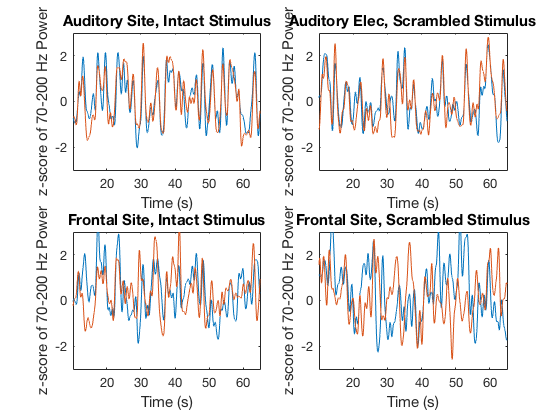

In [21]:

%% Let's plot the broadband power timeseries across the two repeats, for each condition and electrode...

tt = find(and(timebase > 10, timebase < 65));   %define a convenient time window for viewing data

figure(10)
subplot(2,2,1)
plot(timebase(tt), [pow_aud_intact_1(tt) pow_aud_intact_2(tt)])
title('Auditory Site, Intact Stimulus')

subplot(2,2,2)
plot(timebase(tt), [pow_aud_scram_1(tt) pow_aud_scram_2(tt)])
title('Auditory Elec, Scrambled Stimulus')

subplot(2,2,3)
plot(timebase(tt), [pow_pfc_intact_1(tt) pow_pfc_intact_2(tt)])
title('Frontal Site, Intact Stimulus')

subplot(2,2,4)
plot(timebase(tt), [pow_pfc_scram_1(tt) pow_pfc_scram_2(tt)])
title('Frontal Site, Scrambled Stimulus')



myaxis = [timebase(tt(1))  timebase(tt(end))  -3 3];
for ip = 1:4
    subplot(2,2,ip)
    axis(myaxis)
    xlabel('Time (s)'); ylabel('z-score of 70-200 Hz Power'); 
end

----
Sensory repeat corr INTACT: 0.82
Sensory repeat corr SCRAM: 0.81
Frontal repeat corr INTACT: 0.48
Frontal repeat corr SCRAM: 0.16


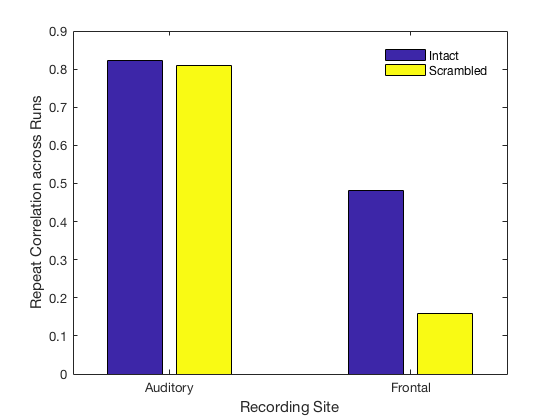

In [22]:

%%
% How reliable are the time series across repetitions?

r_aud_intact = corr(pow_aud_intact_1, pow_aud_intact_2);
r_aud_scram = corr(pow_aud_scram_1, pow_aud_scram_2);
r_pfc_intact = corr(pow_pfc_intact_1, pow_pfc_intact_2);
r_pfc_scram = corr(pow_pfc_scram_1, pow_pfc_scram_2);

fprintf('----\n')
fprintf('Sensory repeat corr INTACT: %2.2f\n', corr(pow_aud_intact_1, pow_aud_intact_2))
fprintf('Sensory repeat corr SCRAM: %2.2f\n', corr(pow_aud_scram_1, pow_aud_scram_2))

fprintf('Frontal repeat corr INTACT: %2.2f\n', corr(pow_pfc_intact_1, pow_pfc_intact_2))
fprintf('Frontal repeat corr SCRAM: %2.2f\n', corr(pow_pfc_scram_1, pow_pfc_scram_2))

figure(2)
bar([r_aud_intact r_aud_scram; r_pfc_intact r_pfc_scram])
xlabel('Recording Site'); set(gca, 'XTickLabel', {'Auditory', 'Frontal'})
ylabel('Repeat Correlation across Runs')
legend('Intact', 'Scrambled'); legend boxoff


In [13]:
%% What proportion of the signal is _very_ slow within each timeseries?
fq_low = 0.05;
do_hamming = true;

alf_aud_intact_1 = calcALF(pow_aud_intact_1, fs, fq_low, do_hamming);
alf_aud_intact_2 = calcALF(pow_aud_intact_2, fs, fq_low, do_hamming);

alf_aud_scram_1 = calcALF(pow_aud_scram_1, fs, fq_low, do_hamming);
alf_aud_scram_2 = calcALF(pow_aud_scram_2, fs, fq_low, do_hamming);

alf_pfc_intact_1 = calcALF(pow_pfc_intact_1, fs, fq_low, do_hamming);
alf_pfc_intact_2 = calcALF(pow_pfc_intact_2, fs, fq_low, do_hamming);

alf_pfc_scram_1 = calcALF(pow_pfc_scram_1, fs, fq_low, do_hamming);
alf_pfc_scram_2 = calcALF(pow_pfc_scram_2, fs, fq_low, do_hamming);


fprintf('---------\n')
fprintf('Slow fluctuations in sensory channel INTACT: %2.1f %% below %2.2f Hz. \n',100 * (alf_aud_intact_1 + alf_aud_intact_2)/2, fq_low)
fprintf('Slow fluctuations in sensory channel SCRAM: %2.1f %% below %2.2f Hz. \n',100 * (alf_aud_scram_1 + alf_aud_scram_2)/2, fq_low)
fprintf('Slow fluctuations in frontal channel INTACT: %2.1f %% below %2.2f Hz. \n',100 * (alf_pfc_intact_1 + alf_pfc_intact_2)/2, fq_low)
fprintf('Slow fluctuations in frontal channel SCRAM: %2.1f %% below %2.2f Hz. \n',100 * (alf_pfc_scram_1 + alf_pfc_scram_2)/2, fq_low)


---------
Slow fluctuations in sensory channel INTACT: 26.1 % below 0.05 Hz. 
Slow fluctuations in sensory channel SCRAM: 9.8 % below 0.05 Hz. 
Slow fluctuations in frontal channel INTACT: 31.5 % below 0.05 Hz. 
Slow fluctuations in frontal channel SCRAM: 20.4 % below 0.05 Hz. 


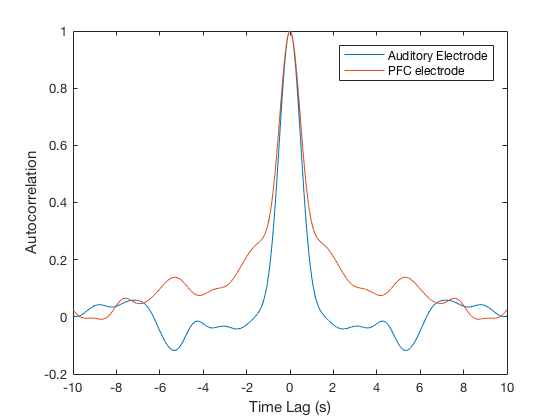

In [23]:

%% What does the temporal autocorrelation look like?

figure(4)
[xc_pfc11, lags] = xcorr(pow_pfc_intact_1, 'coeff');
[xc_aud11, lags] = xcorr(pow_aud_scram_1, 'coeff');
plot(lags/fs, [xc_aud11 xc_pfc11])
xlabel('Time Lag (s)'); ylabel('Autocorrelation');
legend('Auditory Electrode', 'PFC electrode')
axis([-10 10 -0.2 1])
